# ```Project Name: ``` Second Sight Through Machine Learning




### ```Project Dataset:``` [IAM Dataset](https://fki.tic.heia-fr.ch/databases/iam-handwriting-database)

### ```Data type: ``` 
- Handwritten text images (in English)

### ```Objectives: ```
##### For this course:
- Proof of Concept of Optical Character Recognization models
- Create a model(s) that can accurately identify handwritten text
- Model should correct for misspelled words

##### Capstone and Beyond:
- Create a text recognization Mobile Application for visually-impaired people
- Identify handwritten, currency, typed text, and computer screen text
- All functions must be performed on device.
- 100% free for download and use

### ```Key Sections: ```

- Section 1. Data Pipeline
- Section 2. Data Exploration Analysis
- Section 3. Data Preprocessing
- Section 4. Baseline Model (CNN + CTC Loss/Decoder)
- Section 5. Enhanced Model (CNN + RNN/LSTM + CTC)
- Section 6. Target Model (CNN + RNN/LSTM + CTC + NLP Spell Check

# Section 1. Data Pipeline

In [5]:
# Import tools and libraries

import os, time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import sklearn
import pandas as pd
import string
from collections import Counter

import tensorflow as tf
import tensorflow.keras.backend as K
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Reshape, BatchNormalization, Input, Conv2D, MaxPool2D, Lambda, Bidirectional
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import to_categorical, Sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import initializers

import cv2
import imageio # use imread function to read the image
from PIL import Image

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud # visualization

# NLP spell checker
from autocorrect import Speller  

np.random.seed(42)
tf.random.set_seed(42)

### Open the label file (words.txt) and get the lable lines

In [6]:
# Download the IAM dataset to the 'data' folder and open the file
# Labels are stored in words.txt file
#################################################################

base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # remove errored entries
        words_list.append(line)

print("Total label size:", len(words_list))

# print one example of the label line
print(words_list[0])

Total label size: 96456
a01-000u-00-00 ok 154 408 768 27 51 AT A



### Split label line data into training, validation and test

In [13]:
# randomly shuffle the label data
# Use 90% data for training, 5% for validation and 5% for test
####################################################################

np.random.shuffle(words_list)

split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

# validate data split is done correctly
assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training size: {len(train_samples)}")
print(f"Total validation size: {len(validation_samples)}")
print(f"Total test size: {len(test_samples)}")
print(f"Total data size: {len(words_list)}")
print("\nA sample label line:", train_samples[0])

Total training size: 86810
Total validation size: 4823
Total test size: 4823
Total data size: 96456

A sample label line: a04-072-04-00 ok 189 345 1545 353 89 VBD concluded



### Get text images data

In [16]:
# Handwritten text images are stored under the path (./data/words)
# Define a function to get the image path and image data
#################################################################################

base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(base_image_path, partI, partI + "-" + partII, image_name + ".png")
        
        #If the file doesn't exist at the path, path.getsize() will raise a FileNotFoundError exception
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

### Split image data

In [17]:
# use label lines to get images in the image data folder
# split image and label data into training (90%), validation(5%) and test(5%)
##############################################################################

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

### Get the ground-truth labels (words) from the lable lines

In [18]:
# From the label lines, we will retrieve the words and the common charactors in the words
#################################################################################

train_labels_cleaned = []
characters = set()
max_len = 0

# Find maximum length and the size of the vocabulary in the training data
# print(train_img_paths[:5])  #print to see the path
# train_labels[:5]  #print to see the labels
for label in train_labels:
    label = label.split(" ")[-1].strip()  #take the last part of each line which is the word
    for char in label:       #take each charactor the word 
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

characters = sorted(list(characters))

print("Longest word: ", max_len)

# Check some label samples.
print("Print some words:", train_labels_cleaned[:30])


Longest word:  21
Print some words: ['concluded', 'he', 'ever', 'the', ',', 'that', 'The', 'discovering', '.', 'disciples', 'aged', 'started', ',', 'of', 'problems', 'Motor', 'just', 'as', 'the', 'any', 'disciples', 'has', 'out', '3', 'as', 'Nkrumah', 'travel', 'when', ',', 'folly']


In [19]:
# clean the validation and the test labels
#################################################################################

def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

# Section 2. Data Exploration Analysis

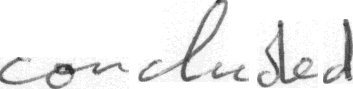

Label: data/words/a04/a04-072/a04-072-04-00.png
Metal device set to: Apple M2
Image_1 shape(height, width, channel): (89, 353, 1)
Image_1 data type: <dtype: 'uint8'>


In [20]:
#Using one example to learn about the image and data structure
#################################################################################

display(load_img(train_img_paths[0]))
print("Label:", train_img_paths[0])
img_1_raw = tf.io.read_file(train_img_paths[0])
img_1 = tf.image.decode_image(img_1_raw)
# print(img_1)
print('Image_1 shape(height, width, channel):', img_1.shape)
print('Image_1 data type:', img_1.dtype)
#img_1.shape shows height and weight

In [21]:
# understand the image shape and channel using the imageio imread function
#################################################################################

im = imageio.imread(train_img_paths[0])
print("First imgage's Shape:", im.shape)

#print the first five labels
print("\nFirst five examples", train_labels_cleaned[0:5])

First imgage's Shape: (89, 353)

First five examples ['concluded', 'he', 'ever', 'the', ',']


/var/folders/8y/pn6zc4td4gqgzdkjr1wqvzs00000gn/T/ipykernel_2446/2484595286.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(train_img_paths[0])


In [22]:
# Print the total number of lablels
#################################################################################

print("Total count of labels is:", (len(words_list)))
# Find out the number of unique labels
unique_labels =set(train_labels_cleaned)
print("The count of unique labels is", len(unique_labels))

Total count of labels is: 96456
The count of unique labels is 11537


#### There are 96,456 labels (text/words) and 12,214 unique text labels in the dataset. We can develop a model to predict by each whole label. Alternatively, we can treat each label as a combination of the letters and symbols, and train a model to identify the underlying letters and symbols.

#### Let's find out what the total count of the underlying characters (including symbols) that are common to our text labels

In [23]:
print("Characters size: ", len(characters))
print("\nPrint the characters:", characters)

Characters size:  78

Print the characters: ['!', '"', '#', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


#### Compared to the 12,214 unque text labels, there are only 78 uniqe letters and symbols underlying all labels. It may be much more efficient to train a model to recognize the letters and symbols that form a text. The model may generalize better as well.

In [24]:
#Indentify the most popular words or symbols
#################################################################################

label_dict = {}
for x in train_labels_cleaned:
    if x in label_dict:        
        label_dict[x] += 1
    else:
        label_dict[x] = 1
sorted_label_dict = {key: value for (key, value) in sorted(label_dict.items(), key=lambda x: x[1], reverse=True)}
most_popular_15 = list(sorted_label_dict.keys())[:15]

# most_popular_15
df_dict = pd.DataFrame(sorted_label_dict.items())
df_dict.columns=['Text', "Count"] 
df_dict['Percent_total'] = df_dict['Count']/df_dict['Count'].sum()*100 
df_dict_top_30 = df_dict[:30]

#### Show the top 30 most popular texts

In [25]:
word_could_dict = label_dict
mask = np.array(Image.open("..\\w207_Projects\\note.JFIF"))
wordcloud = WordCloud(width = 1000, height = 500, max_words=30, mask=mask, 
                      background_color='white').generate_from_frequencies(word_could_dict)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
# plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)

# store to file
plt.savefig("top_30.png", format="png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '..\\w207_Projects\\note.JFIF'

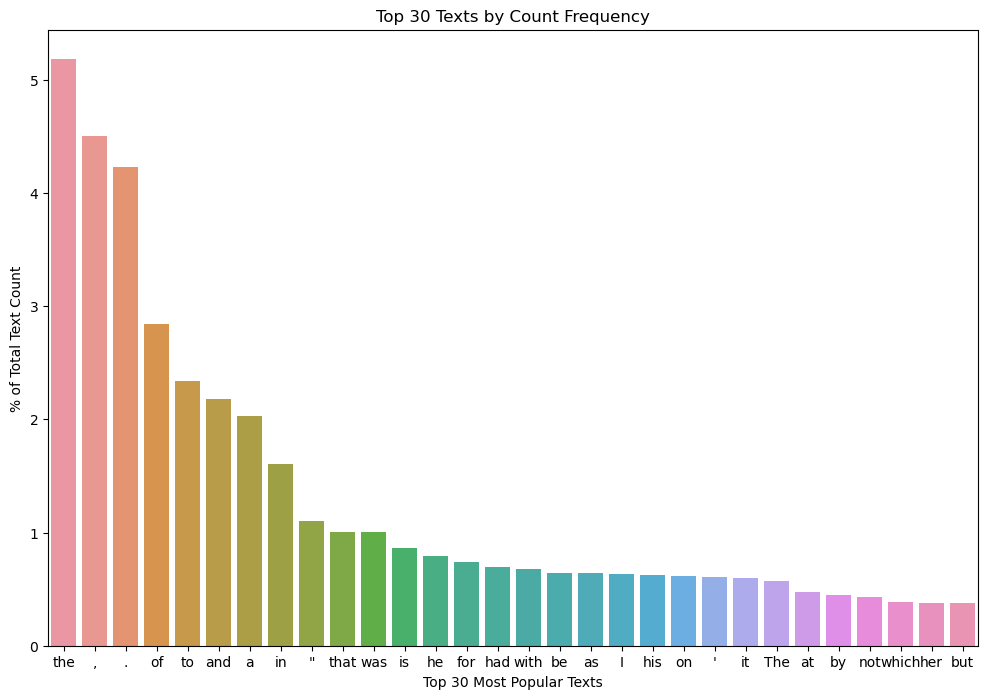

In [26]:
plt.figure(figsize=(12,8))
ax = sns.barplot(x = df_dict_top_30['Text'],
            y = df_dict_top_30['Percent_total'],
            data = df_dict_top_30)
ax.set(xlabel='Top 30 Most Popular Texts', ylabel='% of Total Text Count')
plt.title("Top 30 Texts by Count Frequency")
plt.show()

concluded
(353, 89)


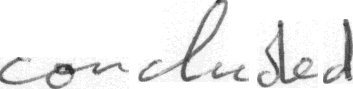

---------------------------
he
(95, 52)


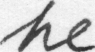

---------------------------
ever
(99, 33)


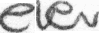

---------------------------
the
(152, 44)


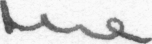

---------------------------
The max width of all images is: 353 
The max height of all images is: 89


In [27]:
#show the first five images
#################################################################################

max_img_width = 0
max_img_height = 0

for i in range(4):
    image = train_img_paths[i]
    label = train_labels_cleaned[i]
    print(label)
    size = load_img(image).size
    if size[0] > max_img_width:
        max_img_width = size[0]
    if size[1] > max_img_height:
        max_img_height = size[1]
    print(size)
    display(load_img(image))
    print("---------------------------")
print("The max width of all images is:", max_img_width, "\nThe max height of all images is:", max_img_height)

# Section 3. Data Preprocessing

### The images in our data set vary in size, let's check out a few examples

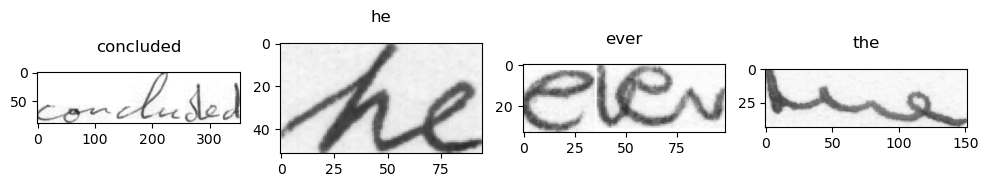

In [28]:
#1 Display the first four images
#################################################################################

def plot_images(image_paths, image_texts, index):
    """
    Display a number of images
    """
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(12,10))
    
    for i in range(index):
        image = image_paths[i]
        label = image_texts[i]
        size = load_img(image).size
        label_name = label
        axs[i].imshow(load_img(image))
        axs[i].set_title(label_name, y=1, pad=15)
#         axs[i].axis('off')
    plt.show()    
  
plot_images(train_img_paths, train_labels_cleaned, 4)

###  In order to improve model performance, we will explore image transformation and augmentation

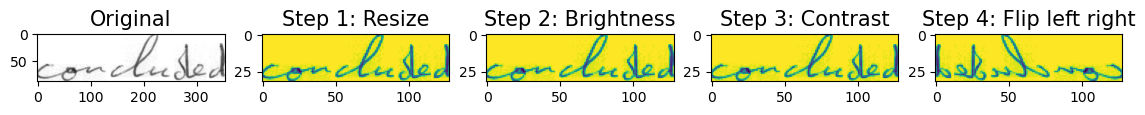

In [29]:
# use one example to explore the image transformation and augmentation techniques
#################################################################################

tf.random.set_seed(1234)

fig = plt.figure(figsize=(14, 12))

# pull first image from data
image = load_img(train_img_paths[0])

# plot original
ax = fig.add_subplot(1, 5, 1)
ax.imshow(image)
ax.set_title('Original', size=15);

#test the image transformation
img_io = tf.io.read_file(train_img_paths[0])

# # 2. Decode and convert to grayscale
img_io = tf.io.decode_png(img_io, channels=1)

# 3. Convert to float32 in [0, 1] range
img_io = tf.image.convert_image_dtype(img_io, tf.float32)

# resize
ax = fig.add_subplot(1, 5, 2)
img_resize = tf.image.resize(img_io, size=(32, 128))
ax.imshow(array_to_img(img_resize))
ax.set_title('Step 1: Resize', size=15);

# adjust brightness
ax = fig.add_subplot(1, 5, 3)
img_bright = tf.image.adjust_brightness(img_resize, 0.3)
ax.imshow(array_to_img(img_bright))
ax.set_title('Step 2: Brightness', size=15);


# adjust contrast
ax = fig.add_subplot(1, 5, 4)
img_contrast = tf.image.adjust_contrast(img_bright, contrast_factor=3)
ax.imshow(array_to_img(img_contrast))
ax.set_title('Step 3: Contrast', size=15);


# flip left right
ax = fig.add_subplot(1, 5, 5)
img_flip = tf.image.flip_left_right(img_contrast)
ax.imshow(array_to_img(img_flip))
ax.set_title('Step 4: Flip left right', size=15);

### Develop a function to standardize the image size

In [30]:
# Resizing images without distortion

def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # add the same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(image, paddings=[[pad_height_top, pad_height_bottom],
                                    [pad_width_left, pad_width_right],
                                    [0, 0],],)
    
    # To improve the model accuracy, use the following techniques to 
    # adjust brightness, adjust contrast, transpose and flip the images
    image = tf.image.adjust_brightness(image, 0.3)
    image = tf.image.adjust_contrast(image, contrast_factor=3)
    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


In [31]:
# Convert character to integer and convert from integer to charactor
#################################################################################

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


In [32]:
# Develop functions to process the image data and labels
#################################################################################

batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)



In [33]:
# use two examples to process the image data and labels
example_2 = prepare_dataset(train_img_paths[0:2], train_labels_cleaned[0:2])

# show the data shape of the image and confirm the image shape is 128 (height) and 32(width)
# color channel is 1 (grey)
for example in example_2.take(1):
    print(example['image'].shape)
    print(example['label'].shape)    
    

(2, 128, 32, 1)
(2, 21)


In [34]:
# Process the data sets (training, validation and test data)
#################################################################################

train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)


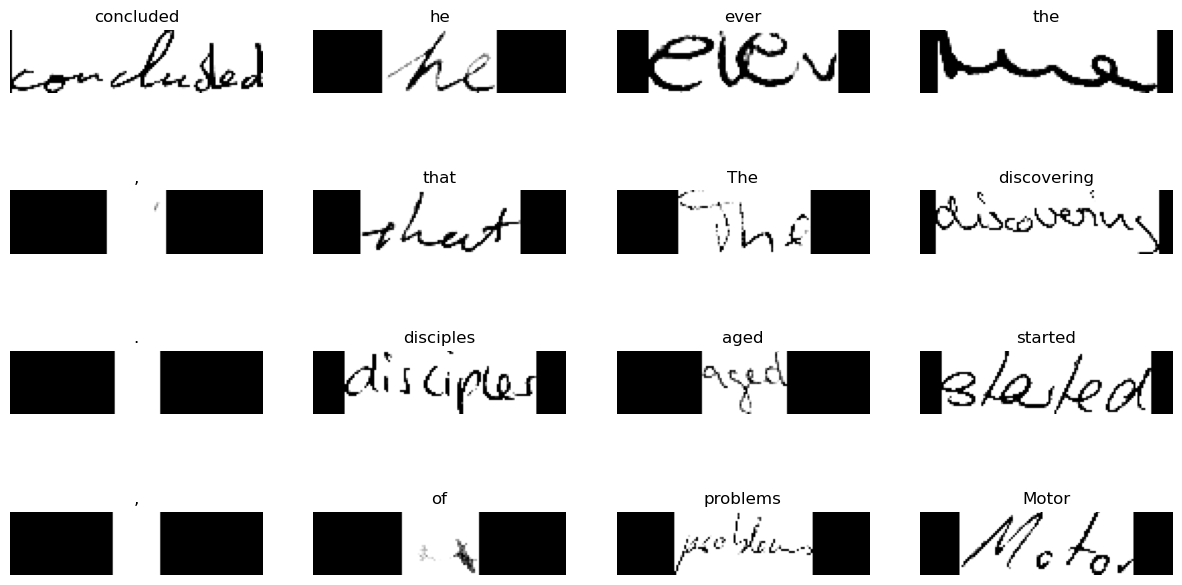

In [35]:
# Visualize a few samples

for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.adjust_brightness(img, 0.3)
        img = tf.image.adjust_contrast(img, contrast_factor=3)
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Model

Our model will use the CTC loss as an endpoint layer. For a detailed understanding of the
CTC loss, refer to [this post](https://distill.pub/2017/ctc/).

In [36]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.

In [132]:
"""
We first segregate the validation images and their labels for convenience.
"""
validation_images = []
validation_labels = []
validation_readable_labels = [validation_labels_cleaned[i: i + batch_size] + [None] * 
                              (i + batch_size - len(validation_labels_cleaned)) 
                              for i in range(0, len(validation_labels_cleaned), batch_size)]

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

"""
Now, we create a callback to monitor the accuracy.
"""
def decode_labels(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

def accuracy_by_letter(pred, actual):
    max_length = max(len(pred), len(actual))
    min_length = min(len(pred), len(actual))
    letters_correct = 0
    for i in range(min_length):
        if pred[i] == actual[i]:
            letters_correct += 1
    return letters_correct / max_length


def calculate_accuracies(labels, predictions)->tuple:
    acc_letter = []
    acc_word = 0
    preds = decode_batch_predictions(predictions)

    for i in range(len(preds)):
        acc_letter.append(accuracy_by_letter(preds[i], labels[i]))
        if preds[i] == labels[i]:
            acc_word += 1
    return (np.mean(acc_letter),  acc_word / len(labels))


class AccuracyCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model
        self.history = {"acc_letter":{}, 
                        "acc_word": {}
                       }

    def on_epoch_end(self, epoch, logs=None):
        letter_accuracies = []
        word_accuracies = []

        for i in range(len(validation_images)):
            labels = validation_readable_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            acc_letter, acc_word = calculate_accuracies(labels, predictions)
            letter_accuracies.append(acc_letter)
            word_accuracies.append(acc_word)

        self.history["acc_letter"][str(epoch + 1)] = np.mean(acc_letter)
        self.history["acc_word"][str(epoch + 1)] = np.mean(acc_word)
        
        print(
            f"Mean accuracy by letter for epoch {epoch + 1}: {np.mean(acc_letter):.4f}"
        )
        print(
            f"Mean accuracy by word for epoch {epoch + 1}: {np.mean(acc_word):.4f}"
        )

In [171]:
# test one epoch
epochs = 5  

model_t = build_model()
prediction_model = keras.models.Model(
    model_t.get_layer(name="image").input, model_t.get_layer(name="dense2").output
)
accuracy_callback = AccuracyCallback(prediction_model)

# Train the model.
history_t = model_t.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[accuracy_callback],
)

Epoch 1/5
1/1 [==============================] - 1s 1s/step
Mean accuracy by letter for epoch 1: 0.1982
Mean accuracy by word for epoch 1: 0.0469
1357/1357 [==============================] - 706s 517ms/step - loss: 13.1121 - val_loss: 10.4614
Epoch 2/5
1/1 [==============================] - 0s 160ms/step
Mean accuracy by letter for epoch 2: 0.3252
Mean accuracy by word for epoch 2: 0.0625
1357/1357 [==============================] - 594s 438ms/step - loss: 8.3787 - val_loss: 6.4003


Epoch 3/5
1/1 [==============================] - 0s 165ms/step
Mean accuracy by letter for epoch 3: 0.5341
Mean accuracy by word for epoch 3: 0.0938
1357/1357 [==============================] - 545s 402ms/step - loss: 5.4373 - val_loss: 4.3441
Epoch 4/5
1/1 [==============================] - 0s 145ms/step
Mean accuracy by letter for epoch 4: 0.6409
Mean accuracy by word for epoch 4: 0.1250
1357/1357 [==============================] - 551s 406ms/step - loss: 4.1747 - val_loss: 3.7119


Epoch 5/5
1/1 [==============================] - 0s 108ms/step
Mean accuracy by letter for epoch 5: 0.6361
Mean accuracy by word for epoch 5: 0.1562
1357/1357 [==============================] - 533s 393ms/step - loss: 3.5065 - val_loss: 3.2828


In [172]:
acc_history_df = pd.DataFrame(accuracy_callback.history, columns=["acc_letter", "acc_word"])
acc_history_df["epoch"] = acc_history_df.index+1
acc_history_df

,acc_letter,acc_word,epoch
0,0.198240,0.046875,1
1,0.325174,0.062500,2
2,0.534074,0.093750,3
3,0.640871,0.125000,4
4,0.636147,0.156250,5


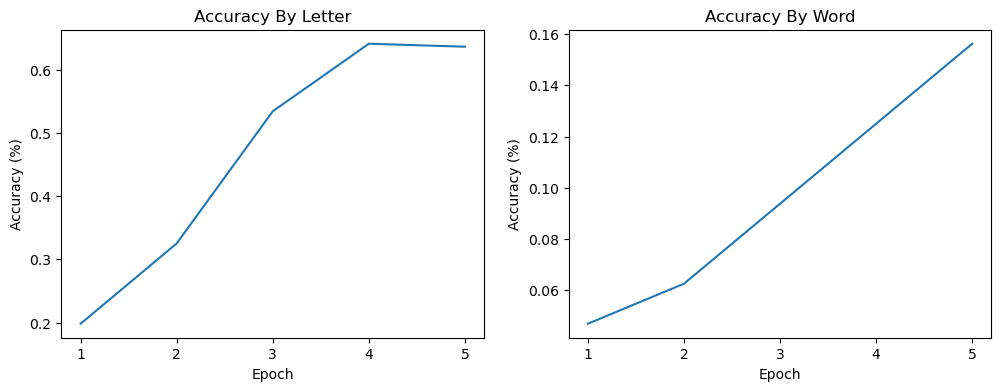

In [173]:
fig, ax = plt.subplots(1,2, figsize=(12, 4)) #, sharey=True)
sns.lineplot(data=acc_history_df, x="epoch", y="acc_letter", ax=ax[0])
ax[0].set_title("Accuracy By Letter")
ax[0].set_ylabel("Accuracy (%)")
ax[0].set_xlabel("Epoch")
ax[0].set_xticks(acc_history_df["epoch"])

sns.lineplot(data=acc_history_df, x="epoch", y="acc_word", ax=ax[1])
ax[1].set_title("Accuracy By Word")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(acc_history_df["epoch"])


## Training

Now we are ready to kick off model training.

In [16]:
epochs = 10  # To get good results this should be at least 50.

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)

Epoch 1/10
1/1 [==============================] - 1s 1s/step
Mean edit distance for epoch 1: 20.4877
1357/1357 [==============================] - 531s 385ms/step - loss: 13.7431 - val_loss: 11.9581
Epoch 2/10
1/1 [==============================] - 0s 44ms/step
Mean edit distance for epoch 2: 20.1865
1357/1357 [==============================] - 341s 251ms/step - loss: 10.8193 - val_loss: 9.8493


Epoch 3/10
1/1 [==============================] - 0s 41ms/step
Mean edit distance for epoch 3: 19.9333
1357/1357 [==============================] - 332s 245ms/step - loss: 9.2549 - val_loss: 8.3668
Epoch 4/10
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 4: 19.2563
1357/1357 [==============================] - 335s 247ms/step - loss: 7.8334 - val_loss: 6.4428


Epoch 5/10
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 5: 18.6673
1357/1357 [==============================] - 342s 252ms/step - loss: 6.4183 - val_loss: 5.1255
Epoch 6/10
1/1 [==============================] - 0s 42ms/step
Mean edit distance for epoch 6: 18.3217
1357/1357 [==============================] - 336s 248ms/step - loss: 5.3813 - val_loss: 4.2332


Epoch 7/10
1/1 [==============================] - 0s 40ms/step
Mean edit distance for epoch 7: 18.1088
1357/1357 [==============================] - 343s 253ms/step - loss: 4.6768 - val_loss: 3.6994
Epoch 8/10
1/1 [==============================] - 0s 39ms/step
Mean edit distance for epoch 8: 17.9775
1357/1357 [==============================] - 344s 254ms/step - loss: 4.2007 - val_loss: 3.3573


Epoch 9/10
1/1 [==============================] - 0s 49ms/step
Mean edit distance for epoch 9: 17.8347
1357/1357 [==============================] - 348s 256ms/step - loss: 3.8659 - val_loss: 3.0603
Epoch 10/10
1/1 [==============================] - 0s 47ms/step
Mean edit distance for epoch 10: 17.7748
1357/1357 [==============================] - 366s 270ms/step - loss: 3.5882 - val_loss: 2.8413


In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

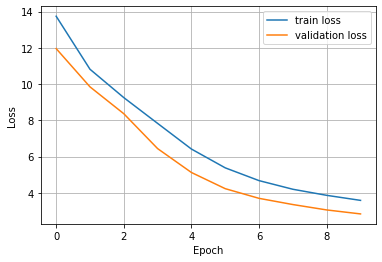

In [23]:
plot_loss(history)

In [34]:
 test_accuracy = model.evaluate(test_ds, verbose=0,
                                 return_dict=True)
 test_accuracy

{'loss': 11.143865585327148}

#  Lisa: Experiment

In [89]:
def build_model_2(kernel_size=(3, 3),
                  strides=(1, 1),
                  pool_size=(2, 2),
                  learning_rate=0.001,
                  optimizer='Adam',                    
                  num_epochs=6):
    
    """ build the model"""
    start_line = f'kernel_size:{kernel_size}\\strides:{strides}\\pool_size:{pool_size}\\Learning_Rate:{learning_rate}\\Optimizer:{optimizer}\\ epochs:{num_epochs}'
    print(f'******************************************')
    print(f'\n\nTrain and Evaluate with: {start_line}')
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv1")(input_img)
        
    x = keras.layers.MaxPooling2D(pool_size=pool_size, name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=kernel_size,
        strides=strides,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv2")(x)
    
    x = keras.layers.MaxPooling2D(pool_size=pool_size, name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(200, return_sequences=True, dropout=0.20)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.20)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.20)
    )(x)


    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="OCR"
    )
    # Optimizer.
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    # Compile the model and return.
    model.compile(optimizer=opt)
    
    return model


# Get the model.
model = build_model_2()
model.summary()

******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:6
Model: "OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv1[0][0]']                  
                             

In [80]:
#Alternative iterations
epochs_2 = 5  # To get good results this should be at least 50.
model_2 = build_model_2()
prediction_model_2 = keras.models.Model(
    model_2.get_layer(name="image").input, model_2.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model_2)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs_2,
    callbacks=[edit_distance_callback],
)

******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:6
Epoch 1/5
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.9217
1357/1357 [==============================] - 1406s 1s/step - loss: 13.3842 - val_loss: 11.7236
Epoch 2/5
1/1 [==============================] - 0s 178ms/step
Mean edit distance for epoch 2: 20.9217
1357/1357 [==============================] - 1412s 1s/step - loss: 10.3892 - val_loss: 9.1058
Epoch 3/5
1/1 [==============================] - 0s 197ms/step
Mean edit distance for epoch 3: 20.9217
1357/1357 [==============================] - 1391s 1s/step - loss: 8.2284 - val_loss: 6.8557
Epoch 4/5
2/2 [==============================] - 0s 228ms/step


1/1 [==============================] - 0s 174ms/step
Mean edit distance for epoch 4: 20.9217
1357/1357 [==============================] - 1370s 1s/step - loss: 6.2450 - val_loss: 4.9944
Epoch 5/5
1/1 [==============================] - 0s 190ms/step
Mean edit distance for epoch 5: 20.9217
1357/1357 [==============================] - 1433s 1s/step - loss: 4.8622 - val_loss: 3.8519


In [81]:
history.history

{'loss': [13.384244918823242,
  10.389245986938477,
  8.228423118591309,
  6.245001792907715,
  4.862170696258545],
 'val_loss': [11.723642349243164,
  9.105842590332031,
  6.855700969696045,
  4.994365692138672,
  3.8518686294555664]}

In [88]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [113]:
preds = prediction_model.predict(test_ds)
pred_texts = decode_batch_predictions(preds)
pred_texts[:20]


76/76 [==============================] - 10s 122ms/step


['attered',
 'Here',
 ',',
 'the',
 'It',
 'up',
 'adges',
 'The',
 'postion',
 'sceakched',
 "afficer'y",
 'to',
 'bke',
 'wouted',
 ',',
 'sreen',
 'inmpiration',
 '.',
 'Hhe',
 'irritatea']

In [141]:
#define accuracy metrices
def accuracy_by_letter(pred, labels):
    max_length = max(len(pred), len(labels))
    min_length = min(len(pred), len(labels))
    
    letters_correct = 0
    
    for i in range(min_length):
        if pred[i] == labels[i]:
            letters_correct += 1
    
    return letters_correct

def accuracy_matrix (pred, labels):
    """calculate accuracy""" 
    results = pd.DataFrame(columns=["actual", "prediction", "corrected_predictions"])
    results["actual"] = labels
    results["prediction"] = pred
    results["corrected_predictions"] = results["actual"] == results["prediction"]
    results['percent_accurate_letter'] = results.apply(lambda x:
                                                   accuracy_by_letter(x.actual, x.prediction), axis=1)/results["actual"].str.len()
    acc_word = results['corrected_predictions'].mean()
    acc_letter = results['percent_accurate_letter'].mean()
    print(f"Accuracy by word: {acc_word:.4f}")
    print(f"Accuracy by letter: {acc_letter:.4f}")
    return acc_word, acc_letter

accuracy_metrix (pred_texts, test_labels_cleaned)


Accuracy by word: 0.5872
Accuracy by letter: 0.7792


(0.5871863985071533, 0.7792156739751598)

In [137]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss') # val_loss is the validation/test data
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)


def plot_loss_2(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1

    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)

#     ax = fig.add_subplot(1, 2, 2)
#     ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
#     ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
#     ax.legend(fontsize=15)
#     ax.set_xlabel('Epoch', size=15)
#     ax.set_ylabel('Accuracy', size=15)
    plt.show()

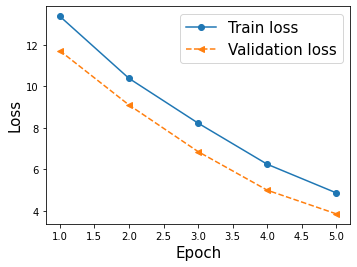

In [83]:
plot_loss_2(history)

In [139]:
test_accuracy = model.evaluate(test_ds, verbose=0,
                                 return_dict=True)
test_accuracy

KeyError: 'accuracy'

In [145]:

def train_and_evaluate(kernel_size=(3, 3),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',                    
                       num_epochs=15):
    """ train and evaluate"""
#     start_line = f'kernel_size:{kernel_size}\\strides:{strides}\\pool_size:{pool_size}\\Learning_Rate:{learning_rate}\\Optimizer:{optimizer}\\ epochs:{num_epochs}'
#     print(f'******************************************')
#     print(f'\n\nTrain and Evaluate with: {start_line}')
    
    start_time = time.time()
    # Build the model.
    tf.random.set_seed(1)
    model = build_model_2(kernel_size=kernel_size,
                          strides=strides,
                          pool_size=pool_size,
                          learning_rate=learning_rate,
                          optimizer=optimizer,                    
                          num_epochs=num_epochs
    )
    prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    edit_distance_callback = EditDistanceCallback(prediction_model)
    
    # Train the model.
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=num_epochs,
                        callbacks=[edit_distance_callback],)
    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    plot_loss_2(history)
    
#     #retrieve final training and validation accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
#     final_train_loss = train_accuracy[-1:]
#     final_val_loss = val_accuracy[-1:]

    test_loss = model.evaluate(test_ds, verbose=0,
                                 return_dict=True)
    
    #determine the accuracy of test data
    preds = prediction_model.predict(test_ds)
    pred_texts = decode_batch_predictions(preds)
    
    test_accuracy = accuracy_metrix (pred_texts, test_labels_cleaned)
    
    total_train_param = sum(count_params(layer) for layer in model.trainable_weights)
  
    time_elapsed = round(time.time() - start_time, 1)
#     final_line = f'Train_time:{time_elapsed} in seconds|parameters:{total_train_param}|train accuracy:{final_train_accuracy}|val accuracy:{final_val_accuracy}|test accuracy:{test_accuracy}'
    final_line = f'Train_time:{time_elapsed} in seconds|parameters:{total_train_param}|test loss:{test_loss}|test accuracy:{test_accuracy}'
    print(f'\n\nFinal Results: {final_line}')
    return test_accuracy

******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:15
Epoch 1/15
1/1 [==============================] - 1s 976ms/step
Mean edit distance for epoch 1: 20.9217
1357/1357 [==============================] - 23303s 17s/step - loss: 13.4650 - val_loss: 11.8710
Epoch 2/15
2/2 [==============================] - 1s 412ms/step


1/1 [==============================] - 0s 307ms/step
Mean edit distance for epoch 2: 20.9217
1357/1357 [==============================] - 2942s 2s/step - loss: 10.6455 - val_loss: 9.4085
Epoch 3/15
1/1 [==============================] - 0s 262ms/step
Mean edit distance for epoch 3: 20.9217
1357/1357 [==============================] - 2073s 2s/step - loss: 8.5932 - val_loss: 7.4629
Epoch 4/15
1/1 [==============================] - 0s 253ms/step
Mean edit distance for epoch 4: 20.9217
1357/1357 [==============================] - 2010s 1s/step - loss: 6.5760 - val_loss: 5.2922
Epoch 5/15
1/1 [==============================] - 0s 250ms/step
Mean edit distance for epoch 5: 20.9217
1357/1357 [==============================] - 1987s 1s/step - loss: 5.0714 - val_loss: 3.9479
Epoch 6/15
2/2 [==============================] - 1s 291ms/step


1/1 [==============================] - 0s 241ms/step
Mean edit distance for epoch 6: 20.9217
1357/1357 [==============================] - 2081s 2s/step - loss: 4.1427 - val_loss: 3.2648
Epoch 7/15
1/1 [==============================] - 0s 252ms/step
Mean edit distance for epoch 7: 20.9217
1357/1357 [==============================] - 2076s 2s/step - loss: 3.5699 - val_loss: 3.0093
Epoch 8/15
1/1 [==============================] - 0s 243ms/step
Mean edit distance for epoch 8: 20.9217
1357/1357 [==============================] - 1991s 1s/step - loss: 3.1641 - val_loss: 2.8546
Epoch 9/15
1/1 [==============================] - 0s 231ms/step
Mean edit distance for epoch 9: 20.9217
1357/1357 [==============================] - 2023s 1s/step - loss: 2.8960 - val_loss: 2.4812
Epoch 10/15
2/2 [==============================] - 1s 296ms/step


1/1 [==============================] - 0s 230ms/step
Mean edit distance for epoch 10: 20.9217
1357/1357 [==============================] - 2025s 1s/step - loss: 2.6706 - val_loss: 2.3788
Epoch 11/15
1/1 [==============================] - 0s 233ms/step
Mean edit distance for epoch 11: 20.9217
1357/1357 [==============================] - 2022s 1s/step - loss: 2.4804 - val_loss: 2.1819
Epoch 12/15
1/1 [==============================] - 0s 230ms/step
Mean edit distance for epoch 12: 20.9217
1357/1357 [==============================] - 2032s 1s/step - loss: 2.3280 - val_loss: 2.2168
Epoch 13/15
1/1 [==============================] - 0s 236ms/step
Mean edit distance for epoch 13: 20.9217
1357/1357 [==============================] - 2037s 2s/step - loss: 2.1950 - val_loss: 2.1023
Epoch 14/15
2/2 [==============================] - 1s 320ms/step


1/1 [==============================] - 0s 231ms/step
Mean edit distance for epoch 14: 20.9217
1357/1357 [==============================] - 2082s 2s/step - loss: 2.0911 - val_loss: 2.0457
Epoch 15/15
1/1 [==============================] - 0s 251ms/step
Mean edit distance for epoch 15: 20.9217
1357/1357 [==============================] - 2045s 2s/step - loss: 2.0016 - val_loss: 1.9693


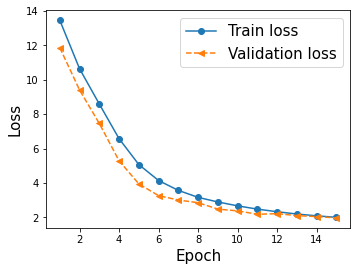

NameError: name 'train_accuracy' is not defined

In [146]:
train_and_evaluate(kernel_size=(3, 3),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',                    
                       num_epochs=15)

In [147]:
preds = prediction_model.predict(test_ds)
pred_texts = decode_batch_predictions(preds)
    
test_accuracy = accuracy_metrix (pred_texts, test_labels_cleaned)

76/76 [==============================] - 16s 206ms/step
Accuracy by word: 0.5872
Accuracy by letter: 0.7792


In [173]:
   
def build_model_3(kernel_size=(3, 3),
                  strides=(1, 1),
                  pool_size=(2, 2),
                  learning_rate=0.001,
                  optimizer='Adam', 
                  hidden_layer_sizes=[200, 128, 64],
                  dropout=0.20,
                  num_epochs=15):
    
    """ build the model"""
    start_line = f'kernel_size:{kernel_size}\\strides:{strides}\\pool_size:{pool_size}\\Learning_Rate:{learning_rate}\\Optimizer:{optimizer}\\ epochs:{num_epochs}'
    print(f'******************************************')
    print(f'\n\nTrain and Evaluate with: {start_line}')
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)
    
    
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        filters=32,
        kernel_size=kernel_size,
        strides=strides,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv1")(input_img)
        
    x = keras.layers.MaxPooling2D(pool_size=pool_size, name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        filters=64,
        kernel_size=kernel_size,
        strides=strides,
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="conv2")(x)
    
    x = keras.layers.MaxPooling2D(pool_size=pool_size, name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    # add layers based on hidden_layer_sizes
    inputs_layer = x
    for i in range(len(hidden_layer_sizes)):
        input = keras.layers.Bidirectional(keras.layers.LSTM(hidden_layer_sizes[i], 
                                                             return_sequences=True, 
                                                             dropout=dropout))(inputs_layer)
        inputs_layer = input                                     
        
    x = inputs_layer

    # +2 is to account for the two special tokens introduced by the CTC loss.
    # The recommendation comes here: https://git.io/J0eXP.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="OCR"
    )
    # Optimizer
    if optimizer=='SGD':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer=='Adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise ValueError('Invalid optimizer: %s' % optimizer)                                       
                                           
    # Compile the model and return.
    model.compile(optimizer=opt)
    
    return model


# Get the model.
model = build_model_2()
model.summary()

******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:6
Model: "OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv1[0][0]']                  
                             

In [207]:
def train_and_evaluate_3(kernel_size=(3, 3),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.20,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=15):
    """ train and evaluate"""
#     start_line = f'kernel_size:{kernel_size}\\strides:{strides}\\pool_size:{pool_size}\\Learning_Rate:{learning_rate}\\Optimizer:{optimizer}\\ epochs:{num_epochs}'
#     print(f'******************************************')
#     print(f'\n\nTrain and Evaluate with: {start_line}')
    
    start_time = time.time()
    # Build the model.
    tf.random.set_seed(1)
    model = build_model_3(kernel_size=kernel_size,
                          strides=strides,
                          pool_size=pool_size,
                          learning_rate=learning_rate,
                          optimizer=optimizer,
                          dropout=dropout,
                          hidden_layer_sizes=hidden_layer_sizes,
                          num_epochs=num_epochs
    )
    prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output)
    edit_distance_callback = EditDistanceCallback(prediction_model)
    
    # Train the model.
    tf.random.set_seed(1234)
    np.random.seed(1234)
    
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=num_epochs,
                        callbacks=[edit_distance_callback],)
    # Retrieve the training metrics (after each train epoch) and the final test
    # accuracy.
    plot_loss_2(history)
    
#     #retrieve final training and validation accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
#     final_train_loss = train_accuracy[-1:]
#     final_val_loss = val_accuracy[-1:]

    test_loss = model.evaluate(test_ds, verbose=0,
                                 return_dict=True)
    
    #determine the accuracy of test data
    preds = prediction_model.predict(test_ds)
    pred_texts = decode_batch_predictions(preds)
    
    test_accuracy = accuracy_metrix (pred_texts, test_labels_cleaned)
    
    total_train_param = sum(count_params(layer) for layer in model.trainable_weights)
    
        
    time_elapsed = round(time.time() - start_time, 1)
#     final_line = f'Train_time:{time_elapsed} in seconds|parameters:{total_train_param}|train accuracy:{final_train_accuracy}|val accuracy:{final_val_accuracy}|test accuracy:{test_accuracy}'
    final_line = f'Train_time:{time_elapsed} in seconds|parameters:{total_train_param}|test loss:{test_loss}|test accuracy:{test_accuracy}'
    print(f'\n\nFinal Results: {final_line}')
    
    
    
    return prediction_model, test_accuracy, preds, pred_texts, history

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:15
Epoch 1/15
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4132
1357/1357 [==============================] - 2003s 1s/step - loss: 13.4247 - val_loss: 11.7211
Epoch 2/15
1/1 [==============================] - 0s 180ms/step
Mean edit distance for epoch 2: 19.9276
1357/1357 [==============================] - 1712s 1s/step - loss: 10.3921 - val_loss: 9.1933
Epoch 3/15
1/1 [==============================] - 0s 187ms/step
Mean edit distance for epoch 3: 19.4165
1357/1357 [==============================] - 1708s 1s/step - loss: 8.5444 - val_loss: 7.3721
Epoch 4/15
2/2 [==============================] - 1s 319ms/step


1/1 [==============================] - 0s 184ms/step
Mean edit distance for epoch 4: 18.7992
1357/1357 [==============================] - 1700s 1s/step - loss: 6.7725 - val_loss: 5.6501
Epoch 5/15
1/1 [==============================] - 0s 259ms/step
Mean edit distance for epoch 5: 18.2818
1357/1357 [==============================] - 1701s 1s/step - loss: 5.3767 - val_loss: 4.2700
Epoch 6/15
1/1 [==============================] - 0s 195ms/step
Mean edit distance for epoch 6: 18.0055
1357/1357 [==============================] - 1735s 1s/step - loss: 4.5095 - val_loss: 3.5946
Epoch 7/15
1/1 [==============================] - 0s 211ms/step
Mean edit distance for epoch 7: 17.8968
1357/1357 [==============================] - 1708s 1s/step - loss: 3.9514 - val_loss: 3.2227
Epoch 8/15
2/2 [==============================] - 1s 285ms/step


1/1 [==============================] - 0s 184ms/step
Mean edit distance for epoch 8: 17.8447
1357/1357 [==============================] - 1703s 1s/step - loss: 3.5501 - val_loss: 3.0593
Epoch 9/15
1/1 [==============================] - 0s 189ms/step
Mean edit distance for epoch 9: 17.7152
1357/1357 [==============================] - 1699s 1s/step - loss: 3.2536 - val_loss: 2.7792
Epoch 10/15
1/1 [==============================] - 0s 189ms/step
Mean edit distance for epoch 10: 17.6390
1357/1357 [==============================] - 1699s 1s/step - loss: 3.0087 - val_loss: 2.5624
Epoch 11/15
1/1 [==============================] - 0s 188ms/step
Mean edit distance for epoch 11: 17.6244
1357/1357 [==============================] - 1701s 1s/step - loss: 2.8181 - val_loss: 2.4522
Epoch 12/15
2/2 [==============================] - 1s 286ms/step


1/1 [==============================] - 0s 191ms/step
Mean edit distance for epoch 12: 17.5619
1357/1357 [==============================] - 1698s 1s/step - loss: 2.6528 - val_loss: 2.3018
Epoch 13/15
1/1 [==============================] - 0s 191ms/step
Mean edit distance for epoch 13: 17.5285
1357/1357 [==============================] - 1694s 1s/step - loss: 2.5138 - val_loss: 2.2505
Epoch 14/15
1/1 [==============================] - 0s 210ms/step
Mean edit distance for epoch 14: 17.4994
1357/1357 [==============================] - 1697s 1s/step - loss: 2.3962 - val_loss: 2.1605
Epoch 15/15
1/1 [==============================] - 0s 195ms/step
Mean edit distance for epoch 15: 17.4889
1357/1357 [==============================] - 1699s 1s/step - loss: 2.2882 - val_loss: 2.1391


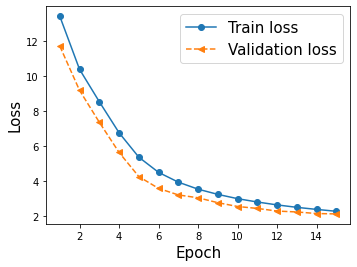

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 29s 355ms/step
Accuracy by word: 0.6842
Accuracy by letter: 0.8468


Final Results: Train_time:25916.9 in seconds|parameters:1181745|test loss:{'loss': 2.155255079269409}|test accuracy:(0.68422143893842, 0.8467993553547157)
******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(2, 2)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:15


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [8, 2, 64], output_shape = [32, 512]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 8, 2, 64), dtype=float32)

In [178]:
parameters_set = {'kernel_size': (2, 2), 
                  'strides': (2,2),
                  'optimizer':'SGD',
                  'hidden_layer_sizes': [128, 64],
                  'dropout': 0.25
                 }

for key, item in parameters_set.items():
    if key == 'kernel_size':
        train_and_evaluate_3(kernel_size = parameters_set[key])
    if key == 'strides':
        train_and_evaluate_3(strides = parameters_set[key])
    if key == 'dropout':
        train_and_evaluate_3(dropout = parameters_set[key])
    if key == 'hidden_layer_sizes':
        train_and_evaluate_3(hidden_layer_sizes = parameters_set[key])
    if key == 'optimizer':
        train_and_evaluate_3(optimizer = parameters_set[key])

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:1
1/1 [==============================] - 3s 3s/step
Mean edit distance for epoch 1: 20.4132
1357/1357 [==============================] - 4007s 3s/step - loss: 13.4247 - val_loss: 11.7211


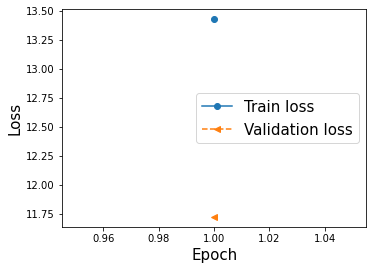

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 89s 1s/step
Accuracy by word: 0.1682
Accuracy by letter: 0.2535


Final Results: Train_time:4188.9 in seconds|parameters:1181745|test loss:{'loss': 11.5540189743042}|test accuracy:(0.16815260211486627, 0.2535410750007478)


In [208]:
history_kernel_2_2 = train_and_evaluate_3(kernel_size=(2, 2),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.20,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=1)

In [209]:
history_kernel_2_2

(<keras.engine.functional.Functional at 0x1c29b9da340>,
 (0.16815260211486627, 0.2535410750007478),
 array([[[8.5921878e-05, 4.7433830e-05, 2.8384416e-04, ...,
          5.1080278e-04, 1.8796494e-04, 9.4646532e-03],
         [4.2848146e-06, 2.1232318e-06, 8.6882312e-05, ...,
          1.4270293e-04, 1.0092442e-05, 2.4290143e-02],
         [1.1062373e-06, 9.7058262e-07, 3.6445792e-05, ...,
          2.1661153e-04, 4.0546220e-06, 5.7275969e-01],
         ...,
         [1.7180237e-06, 2.9161674e-06, 3.3492313e-05, ...,
          3.3960148e-04, 8.2393208e-06, 6.2098509e-01],
         [4.0429286e-06, 7.6439837e-06, 5.4755234e-05, ...,
          2.4575402e-04, 1.3099939e-05, 6.1270231e-01],
         [5.4516055e-05, 4.2659347e-05, 8.3126339e-05, ...,
          6.5224781e-04, 7.9213045e-05, 1.3591082e-01]],
 
        [[1.0567521e-04, 1.3983266e-04, 3.0672897e-04, ...,
          1.8608088e-04, 2.4323905e-04, 1.5799786e-03],
         [4.9156379e-06, 6.3833809e-06, 1.4548999e-04, ...,
          4

In [210]:
history_kernel_2_2.history

AttributeError: 'tuple' object has no attribute 'history'

In [211]:
pred_texts = history_kernel_2_2.pred_texts
pred_texts

AttributeError: 'tuple' object has no attribute 'pred_texts'

In [ ]:
spell = Speller(lang='en')
spell_corrected_preds_2 = [spell(label) for label in pred_texts]

In [ ]:
test_accuracy_spellcheck = accuracy_metrix (spell_corrected_preds_2, test_labels_cleaned)

******************************************


Train and Evaluate with: kernel_size:(3, 3)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:SGD\ epochs:15
Epoch 1/15
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.9249
1357/1357 [==============================] - 1943s 1s/step - loss: 15.5093 - val_loss: 13.9374
Epoch 2/15
1/1 [==============================] - 0s 242ms/step
Mean edit distance for epoch 2: 20.8665
1357/1357 [==============================] - 1923s 1s/step - loss: 13.6925 - val_loss: 13.7779
Epoch 3/15
1/1 [==============================] - 0s 258ms/step
Mean edit distance for epoch 3: 20.8450
1357/1357 [==============================] - 1924s 1s/step - loss: 13.5288 - val_loss: 13.5019
Epoch 4/15
2/2 [==============================] - 1s 458ms/step


1/1 [==============================] - 0s 244ms/step
Mean edit distance for epoch 4: 20.6499
1357/1357 [==============================] - 1927s 1s/step - loss: 12.8930 - val_loss: 12.3588
Epoch 5/15
1/1 [==============================] - 0s 240ms/step
Mean edit distance for epoch 5: 20.4629
1357/1357 [==============================] - 1939s 1s/step - loss: 12.0689 - val_loss: 11.5837
Epoch 6/15
1/1 [==============================] - 0s 246ms/step
Mean edit distance for epoch 6: 20.3147
1357/1357 [==============================] - 1927s 1s/step - loss: 11.1786 - val_loss: 10.4014
Epoch 7/15
1/1 [==============================] - 0s 241ms/step
Mean edit distance for epoch 7: 20.1144
1357/1357 [==============================] - 1927s 1s/step - loss: 10.0947 - val_loss: 9.3880
Epoch 8/15
2/2 [==============================] - 1s 350ms/step


1/1 [==============================] - 0s 241ms/step
Mean edit distance for epoch 8: 19.8637
1357/1357 [==============================] - 1916s 1s/step - loss: 9.1804 - val_loss: 8.3977
Epoch 9/15
1/1 [==============================] - 0s 239ms/step
Mean edit distance for epoch 9: 19.5544
1357/1357 [==============================] - 1930s 1s/step - loss: 8.1816 - val_loss: 7.2387
Epoch 10/15
1/1 [==============================] - 0s 241ms/step
Mean edit distance for epoch 10: 19.0850
1357/1357 [==============================] - 1929s 1s/step - loss: 7.1724 - val_loss: 6.0645
Epoch 11/15
1/1 [==============================] - 0s 285ms/step
Mean edit distance for epoch 11: 18.7369
1357/1357 [==============================] - 1930s 1s/step - loss: 6.1199 - val_loss: 5.1101
Epoch 12/15
2/2 [==============================] - 1s 357ms/step


1/1 [==============================] - 0s 240ms/step
Mean edit distance for epoch 12: 18.3209
1357/1357 [==============================] - 1922s 1s/step - loss: 5.2530 - val_loss: 4.3294
Epoch 13/15
1/1 [==============================] - 0s 239ms/step
Mean edit distance for epoch 13: 18.0786
1357/1357 [==============================] - 1932s 1s/step - loss: 4.6192 - val_loss: 3.7741
Epoch 14/15
1/1 [==============================] - 0s 237ms/step
Mean edit distance for epoch 14: 17.9606
1357/1357 [==============================] - 1940s 1s/step - loss: 4.1172 - val_loss: 3.3682
Epoch 15/15
1/1 [==============================] - 0s 242ms/step
Mean edit distance for epoch 15: 17.8977
1357/1357 [==============================] - 1927s 1s/step - loss: 3.7579 - val_loss: 3.1406


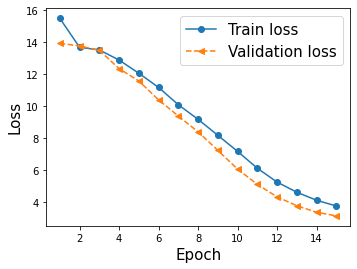

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 37s 461ms/step
Accuracy by word: 0.5706
Accuracy by letter: 0.7513


Final Results: Train_time:29012.6 in seconds|parameters:1192145|test loss:{'loss': 3.11785626411438}|test accuracy:(0.5705992121086461, 0.7512819566339153)


(0.5705992121086461, 0.7512819566339153)

In [179]:
# Use SGD as the optimizer
train_and_evaluate_3(kernel_size=(3, 3),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='SGD',
                       dropout=0.20,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=15)

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:25
Epoch 1/25
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4132
1357/1357 [==============================] - 2181s 2s/step - loss: 13.4247 - val_loss: 11.7211
Epoch 2/25
1/1 [==============================] - 0s 296ms/step
Mean edit distance for epoch 2: 19.9276
1357/1357 [==============================] - 2070s 2s/step - loss: 10.3921 - val_loss: 9.1933
Epoch 3/25
1/1 [==============================] - 0s 267ms/step
Mean edit distance for epoch 3: 19.4165
1357/1357 [==============================] - 1944s 1s/step - loss: 8.5444 - val_loss: 7.3721
Epoch 4/25
2/2 [==============================] - 1s 400ms/step


1/1 [==============================] - 0s 256ms/step
Mean edit distance for epoch 4: 18.7992
1357/1357 [==============================] - 1925s 1s/step - loss: 6.7725 - val_loss: 5.6501
Epoch 5/25
1/1 [==============================] - 0s 255ms/step
Mean edit distance for epoch 5: 18.2818
1357/1357 [==============================] - 1916s 1s/step - loss: 5.3767 - val_loss: 4.2700
Epoch 6/25
1/1 [==============================] - 0s 259ms/step
Mean edit distance for epoch 6: 18.0055
1357/1357 [==============================] - 1931s 1s/step - loss: 4.5095 - val_loss: 3.5946
Epoch 7/25
1/1 [==============================] - 0s 258ms/step
Mean edit distance for epoch 7: 17.8968
1357/1357 [==============================] - 1942s 1s/step - loss: 3.9514 - val_loss: 3.2227
Epoch 8/25
2/2 [==============================] - 1s 406ms/step


1/1 [==============================] - 0s 260ms/step
Mean edit distance for epoch 8: 17.8447
1357/1357 [==============================] - 1965s 1s/step - loss: 3.5501 - val_loss: 3.0593
Epoch 9/25
1/1 [==============================] - 0s 272ms/step
Mean edit distance for epoch 9: 17.7152
1357/1357 [==============================] - 1954s 1s/step - loss: 3.2536 - val_loss: 2.7792
Epoch 10/25
1/1 [==============================] - 0s 335ms/step
Mean edit distance for epoch 10: 17.6390
1357/1357 [==============================] - 2006s 1s/step - loss: 3.0087 - val_loss: 2.5624
Epoch 11/25
1/1 [==============================] - 0s 326ms/step
Mean edit distance for epoch 11: 17.6244
1357/1357 [==============================] - 1957s 1s/step - loss: 2.8181 - val_loss: 2.4522
Epoch 12/25
2/2 [==============================] - 1s 418ms/step


1/1 [==============================] - 0s 255ms/step
Mean edit distance for epoch 12: 17.5619
1357/1357 [==============================] - 1983s 1s/step - loss: 2.6528 - val_loss: 2.3018
Epoch 13/25
1/1 [==============================] - 0s 254ms/step
Mean edit distance for epoch 13: 17.5285
1357/1357 [==============================] - 2020s 1s/step - loss: 2.5138 - val_loss: 2.2505
Epoch 14/25
1/1 [==============================] - 0s 270ms/step
Mean edit distance for epoch 14: 17.4994
1357/1357 [==============================] - 2000s 1s/step - loss: 2.3962 - val_loss: 2.1605
Epoch 15/25
1/1 [==============================] - 0s 289ms/step
Mean edit distance for epoch 15: 17.4889
1357/1357 [==============================] - 2067s 2s/step - loss: 2.2882 - val_loss: 2.1391
Epoch 16/25
2/2 [==============================] - 1s 460ms/step


1/1 [==============================] - 0s 298ms/step
Mean edit distance for epoch 16: 17.4920
1357/1357 [==============================] - 2192s 2s/step - loss: 2.1958 - val_loss: 2.1436
Epoch 17/25
1/1 [==============================] - 0s 376ms/step
Mean edit distance for epoch 17: 17.4594
1357/1357 [==============================] - 2340s 2s/step - loss: 2.1112 - val_loss: 2.0970
Epoch 18/25
1/1 [==============================] - 0s 265ms/step
Mean edit distance for epoch 18: 17.4030
1357/1357 [==============================] - 2126s 2s/step - loss: 2.0272 - val_loss: 1.9570
Epoch 19/25
1/1 [==============================] - 0s 258ms/step
Mean edit distance for epoch 19: 17.4092
1357/1357 [==============================] - 1974s 1s/step - loss: 1.9645 - val_loss: 1.9425
Epoch 20/25
2/2 [==============================] - 1s 409ms/step


1/1 [==============================] - 0s 270ms/step
Mean edit distance for epoch 20: 17.3816
1357/1357 [==============================] - 1972s 1s/step - loss: 1.9109 - val_loss: 1.8982
Epoch 21/25
1/1 [==============================] - 0s 264ms/step
Mean edit distance for epoch 21: 17.3779
1357/1357 [==============================] - 1974s 1s/step - loss: 1.8601 - val_loss: 1.8932
Epoch 22/25
1/1 [==============================] - 0s 293ms/step
Mean edit distance for epoch 22: 17.3849
1357/1357 [==============================] - 2038s 2s/step - loss: 1.7960 - val_loss: 1.8404
Epoch 23/25
1/1 [==============================] - 0s 289ms/step
Mean edit distance for epoch 23: 17.3606
1357/1357 [==============================] - 2070s 2s/step - loss: 1.7379 - val_loss: 1.8231
Epoch 24/25
2/2 [==============================] - 1s 445ms/step


1/1 [==============================] - 0s 284ms/step
Mean edit distance for epoch 24: 17.3598
1357/1357 [==============================] - 2070s 2s/step - loss: 1.6859 - val_loss: 1.7826
Epoch 25/25
1/1 [==============================] - 0s 270ms/step
Mean edit distance for epoch 25: 17.3457
1357/1357 [==============================] - 2059s 2s/step - loss: 1.6613 - val_loss: 1.7965


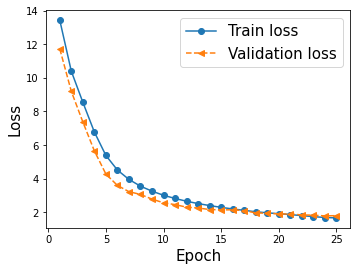

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 48s 610ms/step
Accuracy by word: 0.7280
Accuracy by letter: 0.8736


Final Results: Train_time:50770.8 in seconds|parameters:1181745|test loss:{'loss': 1.7844245433807373}|test accuracy:(0.7279701430644827, 0.8736490043119745)


(0.7279701430644827, 0.8736490043119745)

In [181]:
# Use Adame as the optimizer, increases to 25 epochs
train_and_evaluate_3(kernel_size=(2, 2),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.20,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=25)

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:15
Epoch 1/15
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4409
1357/1357 [==============================] - 2277s 2s/step - loss: 13.4107 - val_loss: 11.7987
Epoch 2/15
1/1 [==============================] - 0s 343ms/step
Mean edit distance for epoch 2: 19.9960
1357/1357 [==============================] - 2250s 2s/step - loss: 10.4410 - val_loss: 9.3287
Epoch 3/15
1/1 [==============================] - 0s 322ms/step
Mean edit distance for epoch 3: 19.5872
1357/1357 [==============================] - 2243s 2s/step - loss: 8.6593 - val_loss: 7.5869
Epoch 4/15
2/2 [==============================] - 1s 551ms/step


1/1 [==============================] - 0s 337ms/step
Mean edit distance for epoch 4: 18.8477
1357/1357 [==============================] - 2237s 2s/step - loss: 6.8604 - val_loss: 5.7361
Epoch 5/15
1/1 [==============================] - 0s 338ms/step
Mean edit distance for epoch 5: 18.3146
1357/1357 [==============================] - 2257s 2s/step - loss: 5.4046 - val_loss: 4.4199
Epoch 6/15
1/1 [==============================] - 0s 328ms/step
Mean edit distance for epoch 6: 18.0752
1357/1357 [==============================] - 2265s 2s/step - loss: 4.4958 - val_loss: 3.6894
Epoch 7/15
1/1 [==============================] - 0s 331ms/step
Mean edit distance for epoch 7: 17.9001
1357/1357 [==============================] - 2255s 2s/step - loss: 3.9079 - val_loss: 3.2393
Epoch 8/15
2/2 [==============================] - 1s 538ms/step


1/1 [==============================] - 0s 327ms/step
Mean edit distance for epoch 8: 17.7908
1357/1357 [==============================] - 2247s 2s/step - loss: 3.5013 - val_loss: 2.9585
Epoch 9/15
1/1 [==============================] - 0s 330ms/step
Mean edit distance for epoch 9: 17.7481
1357/1357 [==============================] - 2244s 2s/step - loss: 3.1996 - val_loss: 2.7632
Epoch 10/15
1/1 [==============================] - 0s 334ms/step
Mean edit distance for epoch 10: 17.7070
1357/1357 [==============================] - 2253s 2s/step - loss: 2.9455 - val_loss: 2.6657
Epoch 11/15
1/1 [==============================] - 0s 334ms/step
Mean edit distance for epoch 11: 17.5856
1357/1357 [==============================] - 2253s 2s/step - loss: 2.7569 - val_loss: 2.4617
Epoch 12/15
2/2 [==============================] - 1s 535ms/step


1/1 [==============================] - 0s 334ms/step
Mean edit distance for epoch 12: 17.6163
1357/1357 [==============================] - 2252s 2s/step - loss: 2.5867 - val_loss: 2.3717
Epoch 13/15
1/1 [==============================] - 0s 336ms/step
Mean edit distance for epoch 13: 17.5430
1357/1357 [==============================] - 2242s 2s/step - loss: 2.4453 - val_loss: 2.2522
Epoch 14/15
1/1 [==============================] - 0s 338ms/step
Mean edit distance for epoch 14: 17.5295
1357/1357 [==============================] - 2233s 2s/step - loss: 2.3263 - val_loss: 2.2387
Epoch 15/15
1/1 [==============================] - 0s 330ms/step
Mean edit distance for epoch 15: 17.5394
1357/1357 [==============================] - 2243s 2s/step - loss: 2.2145 - val_loss: 2.2148


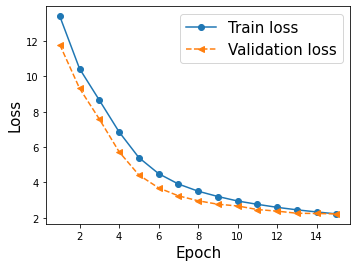

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 52s 656ms/step
Accuracy by word: 0.6726
Accuracy by letter: 0.8400


Final Results: Train_time:33858.4 in seconds|parameters:1181745|test loss:{'loss': 2.1672396659851074}|test accuracy:(0.6726104084594651, 0.8400319423360062)


(0.6726104084594651, 0.8400319423360062)

In [182]:
# Change dropout rate to 0.15
train_and_evaluate_3(kernel_size=(2, 2),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.15,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=15)

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:15
Epoch 1/15
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4449
1357/1357 [==============================] - 2215s 2s/step - loss: 13.4901 - val_loss: 11.8376
Epoch 2/15
1/1 [==============================] - 0s 351ms/step
Mean edit distance for epoch 2: 20.0011
1357/1357 [==============================] - 2259s 2s/step - loss: 10.5681 - val_loss: 9.3372
Epoch 3/15
1/1 [==============================] - 0s 335ms/step
Mean edit distance for epoch 3: 19.5989
1357/1357 [==============================] - 2248s 2s/step - loss: 8.7572 - val_loss: 7.7698
Epoch 4/15
2/2 [==============================] - 1s 579ms/step


1/1 [==============================] - 0s 340ms/step
Mean edit distance for epoch 4: 18.9978
1357/1357 [==============================] - 2255s 2s/step - loss: 7.2903 - val_loss: 6.0834
Epoch 5/15
1/1 [==============================] - 0s 337ms/step
Mean edit distance for epoch 5: 18.4288
1357/1357 [==============================] - 2274s 2s/step - loss: 5.9422 - val_loss: 4.7872
Epoch 6/15
1/1 [==============================] - 0s 355ms/step
Mean edit distance for epoch 6: 18.1856
1357/1357 [==============================] - 2264s 2s/step - loss: 5.0163 - val_loss: 4.0127
Epoch 7/15
1/1 [==============================] - 0s 337ms/step
Mean edit distance for epoch 7: 18.0030
1357/1357 [==============================] - 2297s 2s/step - loss: 4.3743 - val_loss: 3.5329
Epoch 8/15
2/2 [==============================] - 1s 557ms/step


1/1 [==============================] - 0s 340ms/step
Mean edit distance for epoch 8: 17.9185
1357/1357 [==============================] - 2281s 2s/step - loss: 3.9274 - val_loss: 3.3015
Epoch 9/15
1/1 [==============================] - 0s 337ms/step
Mean edit distance for epoch 9: 17.7929
1357/1357 [==============================] - 2237s 2s/step - loss: 3.5828 - val_loss: 2.9733
Epoch 10/15
1/1 [==============================] - 0s 347ms/step
Mean edit distance for epoch 10: 17.7448
1357/1357 [==============================] - 2252s 2s/step - loss: 3.3301 - val_loss: 2.8176
Epoch 11/15
1/1 [==============================] - 0s 414ms/step
Mean edit distance for epoch 11: 17.6996
1357/1357 [==============================] - 2247s 2s/step - loss: 3.1173 - val_loss: 2.6872
Epoch 12/15
2/2 [==============================] - 1s 551ms/step


1/1 [==============================] - 0s 342ms/step
Mean edit distance for epoch 12: 17.6407
1357/1357 [==============================] - 2241s 2s/step - loss: 2.9439 - val_loss: 2.5375
Epoch 13/15
1/1 [==============================] - 0s 336ms/step
Mean edit distance for epoch 13: 17.5719
1357/1357 [==============================] - 2246s 2s/step - loss: 2.7810 - val_loss: 2.3979
Epoch 14/15
1/1 [==============================] - 0s 343ms/step
Mean edit distance for epoch 14: 17.5518
1357/1357 [==============================] - 2383s 2s/step - loss: 2.6600 - val_loss: 2.3333
Epoch 15/15
1/1 [==============================] - 0s 366ms/step
Mean edit distance for epoch 15: 17.5124
1357/1357 [==============================] - 2330s 2s/step - loss: 2.5385 - val_loss: 2.2310


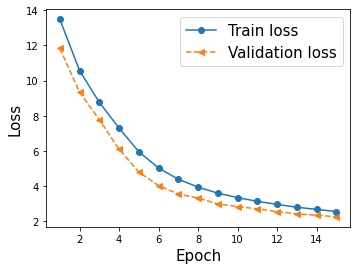

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 58s 730ms/step
Accuracy by word: 0.6739
Accuracy by letter: 0.8428


Final Results: Train_time:34149.9 in seconds|parameters:1181745|test loss:{'loss': 2.168729543685913}|test accuracy:(0.6738544474393531, 0.8428491472473433)


(0.6738544474393531, 0.8428491472473433)

In [183]:
# Change dropout rate to 0.25
train_and_evaluate_3(kernel_size=(2, 2),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.25,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=15)

******************************************


Train and Evaluate with: kernel_size:(2, 2)\strides:(1, 1)\pool_size:(2, 2)\Learning_Rate:0.001\Optimizer:Adam\ epochs:50
Epoch 1/50
1/1 [==============================] - 2s 2s/step
Mean edit distance for epoch 1: 20.4132
1357/1357 [==============================] - 2403s 2s/step - loss: 13.4247 - val_loss: 11.7211
Epoch 2/50
1/1 [==============================] - 0s 367ms/step
Mean edit distance for epoch 2: 19.9276
1357/1357 [==============================] - 2449s 2s/step - loss: 10.3921 - val_loss: 9.1933
Epoch 3/50
1/1 [==============================] - 0s 390ms/step
Mean edit distance for epoch 3: 19.4165
1357/1357 [==============================] - 2458s 2s/step - loss: 8.5444 - val_loss: 7.3721
Epoch 4/50
2/2 [==============================] - 1s 678ms/step


1/1 [==============================] - 1s 501ms/step
Mean edit distance for epoch 4: 18.7992
1357/1357 [==============================] - 2507s 2s/step - loss: 6.7725 - val_loss: 5.6501
Epoch 5/50
1/1 [==============================] - 0s 361ms/step
Mean edit distance for epoch 5: 18.2818
1357/1357 [==============================] - 2475s 2s/step - loss: 5.3767 - val_loss: 4.2700
Epoch 6/50
1/1 [==============================] - 0s 357ms/step
Mean edit distance for epoch 6: 18.0055
1357/1357 [==============================] - 2364s 2s/step - loss: 4.5095 - val_loss: 3.5946
Epoch 7/50
1/1 [==============================] - 0s 359ms/step
Mean edit distance for epoch 7: 17.8968
1357/1357 [==============================] - 2360s 2s/step - loss: 3.9514 - val_loss: 3.2227
Epoch 8/50
2/2 [==============================] - 1s 568ms/step


1/1 [==============================] - 0s 351ms/step
Mean edit distance for epoch 8: 17.8447
1357/1357 [==============================] - 2356s 2s/step - loss: 3.5501 - val_loss: 3.0593
Epoch 9/50
1/1 [==============================] - 0s 381ms/step
Mean edit distance for epoch 9: 17.7152
1357/1357 [==============================] - 2354s 2s/step - loss: 3.2536 - val_loss: 2.7792
Epoch 10/50
1/1 [==============================] - 0s 370ms/step
Mean edit distance for epoch 10: 17.6390
1357/1357 [==============================] - 2364s 2s/step - loss: 3.0087 - val_loss: 2.5624
Epoch 11/50
1/1 [==============================] - 0s 372ms/step
Mean edit distance for epoch 11: 17.6244
1357/1357 [==============================] - 2383s 2s/step - loss: 2.8181 - val_loss: 2.4522
Epoch 12/50
2/2 [==============================] - 1s 569ms/step


1/1 [==============================] - 0s 368ms/step
Mean edit distance for epoch 12: 17.5619
1357/1357 [==============================] - 2366s 2s/step - loss: 2.6528 - val_loss: 2.3018
Epoch 13/50
1/1 [==============================] - 0s 364ms/step
Mean edit distance for epoch 13: 17.5285
1357/1357 [==============================] - 2386s 2s/step - loss: 2.5138 - val_loss: 2.2505
Epoch 14/50
1/1 [==============================] - 0s 364ms/step
Mean edit distance for epoch 14: 17.4994
1357/1357 [==============================] - 2405s 2s/step - loss: 2.3962 - val_loss: 2.1605
Epoch 15/50
1/1 [==============================] - 0s 362ms/step
Mean edit distance for epoch 15: 17.4889
1357/1357 [==============================] - 2411s 2s/step - loss: 2.2882 - val_loss: 2.1391
Epoch 16/50
2/2 [==============================] - 1s 592ms/step


1/1 [==============================] - 0s 361ms/step
Mean edit distance for epoch 16: 17.4920
1357/1357 [==============================] - 2428s 2s/step - loss: 2.1958 - val_loss: 2.1436
Epoch 17/50
1/1 [==============================] - 0s 368ms/step
Mean edit distance for epoch 17: 17.4594
1357/1357 [==============================] - 2434s 2s/step - loss: 2.1112 - val_loss: 2.0970
Epoch 18/50
1/1 [==============================] - 0s 374ms/step
Mean edit distance for epoch 18: 17.4030
1357/1357 [==============================] - 2453s 2s/step - loss: 2.0272 - val_loss: 1.9570
Epoch 19/50
1/1 [==============================] - 0s 393ms/step
Mean edit distance for epoch 19: 17.4092
1357/1357 [==============================] - 2473s 2s/step - loss: 1.9645 - val_loss: 1.9425
Epoch 20/50
2/2 [==============================] - 1s 710ms/step


1/1 [==============================] - 0s 386ms/step
Mean edit distance for epoch 20: 17.3816
1357/1357 [==============================] - 2490s 2s/step - loss: 1.9109 - val_loss: 1.8982
Epoch 21/50
1/1 [==============================] - 0s 397ms/step
Mean edit distance for epoch 21: 17.3779
1357/1357 [==============================] - 2495s 2s/step - loss: 1.8601 - val_loss: 1.8932
Epoch 22/50
1/1 [==============================] - 0s 400ms/step
Mean edit distance for epoch 22: 17.3849
1357/1357 [==============================] - 2495s 2s/step - loss: 1.7960 - val_loss: 1.8404
Epoch 23/50
1/1 [==============================] - 0s 400ms/step
Mean edit distance for epoch 23: 17.3606
1357/1357 [==============================] - 2520s 2s/step - loss: 1.7379 - val_loss: 1.8231
Epoch 24/50
2/2 [==============================] - 1s 632ms/step


1/1 [==============================] - 0s 393ms/step
Mean edit distance for epoch 24: 17.3598
1357/1357 [==============================] - 2543s 2s/step - loss: 1.6859 - val_loss: 1.7826
Epoch 25/50
1/1 [==============================] - 0s 410ms/step
Mean edit distance for epoch 25: 17.3457
1357/1357 [==============================] - 2550s 2s/step - loss: 1.6613 - val_loss: 1.7965
Epoch 26/50
1/1 [==============================] - 0s 414ms/step
Mean edit distance for epoch 26: 17.3579
1357/1357 [==============================] - 2549s 2s/step - loss: 1.6260 - val_loss: 1.8530
Epoch 27/50
1/1 [==============================] - 0s 401ms/step
Mean edit distance for epoch 27: 17.3443
1357/1357 [==============================] - 2555s 2s/step - loss: 1.5691 - val_loss: 1.8270
Epoch 28/50
2/2 [==============================] - 1s 622ms/step


1/1 [==============================] - 0s 406ms/step
Mean edit distance for epoch 28: 17.3231
1357/1357 [==============================] - 2568s 2s/step - loss: 1.5377 - val_loss: 1.7465
Epoch 29/50
1/1 [==============================] - 0s 398ms/step
Mean edit distance for epoch 29: 17.3426
1357/1357 [==============================] - 2576s 2s/step - loss: 1.5158 - val_loss: 1.7752
Epoch 30/50
1/1 [==============================] - 0s 405ms/step
Mean edit distance for epoch 30: 17.3204
1357/1357 [==============================] - 2585s 2s/step - loss: 1.4698 - val_loss: 1.7359
Epoch 31/50
1/1 [==============================] - 0s 414ms/step
Mean edit distance for epoch 31: 17.3227
1357/1357 [==============================] - 2590s 2s/step - loss: 1.4456 - val_loss: 1.7686
Epoch 32/50
2/2 [==============================] - 1s 657ms/step


1/1 [==============================] - 0s 418ms/step
Mean edit distance for epoch 32: 17.3296
1357/1357 [==============================] - 2740s 2s/step - loss: 1.4305 - val_loss: 1.7510
Epoch 33/50
1/1 [==============================] - 0s 435ms/step
Mean edit distance for epoch 33: 17.3296
1357/1357 [==============================] - 2719s 2s/step - loss: 1.3840 - val_loss: 1.7694
Epoch 34/50
1/1 [==============================] - 0s 415ms/step
Mean edit distance for epoch 34: 17.3003
1357/1357 [==============================] - 2657s 2s/step - loss: 1.3808 - val_loss: 1.7125
Epoch 35/50
1/1 [==============================] - 0s 431ms/step
Mean edit distance for epoch 35: 17.2987
1357/1357 [==============================] - 2726s 2s/step - loss: 1.3734 - val_loss: 1.6918
Epoch 36/50
2/2 [==============================] - 1s 677ms/step


1/1 [==============================] - 0s 431ms/step
Mean edit distance for epoch 36: 17.3264
1357/1357 [==============================] - 2753s 2s/step - loss: 1.3176 - val_loss: 1.7799
Epoch 37/50
1/1 [==============================] - 0s 422ms/step
Mean edit distance for epoch 37: 17.3354
1357/1357 [==============================] - 2808s 2s/step - loss: 1.2986 - val_loss: 1.8076
Epoch 38/50
1/1 [==============================] - 0s 457ms/step
Mean edit distance for epoch 38: 17.3167
1357/1357 [==============================] - 2800s 2s/step - loss: 1.2789 - val_loss: 1.7690
Epoch 39/50
2/2 [==============================] - 1s 649ms/step


1/1 [==============================] - 0s 411ms/step
Mean edit distance for epoch 39: 17.3099
1357/1357 [==============================] - 2729s 2s/step - loss: 1.2583 - val_loss: 1.7559
Epoch 40/50
1/1 [==============================] - 0s 429ms/step
Mean edit distance for epoch 40: 17.3121
1357/1357 [==============================] - 2703s 2s/step - loss: 1.2455 - val_loss: 1.7686
Epoch 41/50
1/1 [==============================] - 0s 430ms/step
Mean edit distance for epoch 41: 17.3003
1357/1357 [==============================] - 2714s 2s/step - loss: 1.2360 - val_loss: 1.7048
Epoch 42/50
1/1 [==============================] - 0s 426ms/step
Mean edit distance for epoch 42: 17.2843
1357/1357 [==============================] - 2736s 2s/step - loss: 1.2188 - val_loss: 1.7241
Epoch 43/50
2/2 [==============================] - 1s 676ms/step


1/1 [==============================] - 0s 423ms/step
Mean edit distance for epoch 43: 17.2877
1357/1357 [==============================] - 2747s 2s/step - loss: 1.1808 - val_loss: 1.7002
Epoch 44/50
1/1 [==============================] - 1s 540ms/step
Mean edit distance for epoch 44: 17.2837
1357/1357 [==============================] - 2774s 2s/step - loss: 1.1655 - val_loss: 1.6979
Epoch 45/50
1/1 [==============================] - 0s 437ms/step
Mean edit distance for epoch 45: 17.2826
1357/1357 [==============================] - 2809s 2s/step - loss: 1.1580 - val_loss: 1.6866
Epoch 46/50
1/1 [==============================] - 0s 437ms/step
Mean edit distance for epoch 46: 17.2834
1357/1357 [==============================] - 2783s 2s/step - loss: 1.1424 - val_loss: 1.6991
Epoch 47/50
2/2 [==============================] - 1s 675ms/step


1/1 [==============================] - 0s 437ms/step
Mean edit distance for epoch 47: 17.2960
1357/1357 [==============================] - 2791s 2s/step - loss: 1.1387 - val_loss: 1.7626
Epoch 48/50
1/1 [==============================] - 0s 433ms/step
Mean edit distance for epoch 48: 17.2945
1357/1357 [==============================] - 22629s 17s/step - loss: 1.1105 - val_loss: 1.7635
Epoch 49/50
1/1 [==============================] - 0s 452ms/step
Mean edit distance for epoch 49: 17.2848
1357/1357 [==============================] - 2795s 2s/step - loss: 1.1078 - val_loss: 1.7070
Epoch 50/50
1/1 [==============================] - 0s 456ms/step
Mean edit distance for epoch 50: 17.2779
1357/1357 [==============================] - 2838s 2s/step - loss: 1.0882 - val_loss: 1.7300


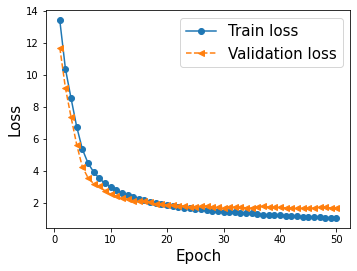

C:\Users\lisaw\anaconda3\lib\site-packages\keras\engine\functional.py:566: UserWarning: Input dict contained keys ['label'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


76/76 [==============================] - 66s 839ms/step
Accuracy by word: 0.7545
Accuracy by letter: 0.8884


Final Results: Train_time:148738.1 in seconds|parameters:1181745|test loss:{'loss': 1.7155747413635254}|test accuracy:(0.7545096413020941, 0.8883517279251271)


(0.7545096413020941, 0.8883517279251271)

In [184]:
# Set to 50 epochs
train_and_evaluate_3(kernel_size=(2, 2),
                       strides=(1, 1),
                       pool_size=(2, 2),
                       learning_rate=0.001,
                       optimizer='Adam',
                       dropout=0.20,
                       hidden_layer_sizes=[200, 128, 64],
                       num_epochs=50)

Model: "OCR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 128, 32, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv1 (Conv2D)                 (None, 128, 32, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 64, 16, 32)   0           ['conv1[0][0]']                  
                                                                                                  
 conv2 (Conv2D)                 (None, 64, 16, 64)   18496       ['pool1[0][0]']                

In [185]:
preds_2 = prediction_model.predict(test_ds)
pred_texts_2 = decode_batch_predictions(preds)
pred_texts_2[:20]

76/76 [==============================] - 35s 448ms/step


['attered',
 'Here',
 ',',
 'the',
 'It',
 'up',
 'adges',
 'The',
 'postion',
 'sceakched',
 "afficer'y",
 'to',
 'bke',
 'wouted',
 ',',
 'sreen',
 'inmpiration',
 '.',
 'Hhe',
 'irritatea']

## NLP Spellchecker

In [197]:
accuracy_metrix (pred_texts_2, test_labels_cleaned)

Accuracy by word: 0.5872
Accuracy by letter: 0.7792


(0.5871863985071533, 0.7792156739751598)

In [190]:


spell = Speller(lang='en')
spell_corrected_preds_2 = [spell(label) for label in pred_texts_2]

print("Predictions:", pred_texts_2[:10])
print("Actuals:", test_labels_cleaned[:10])
print("Spell Corrected:", spell_corrected_preds_2[:10])

Predictions: ['attered', 'Here', ',', 'the', 'It', 'up', 'adges', 'The', 'postion', 'sceakched']
Actuals: ['altered', 'Here', "'", 'the', 'It', 'up', 'edges', 'The', 'position', 'scratched']
Spell Corrected: ['altered', 'Here', ',', 'the', 'It', 'up', 'ages', 'The', 'position', 'searched']


In [191]:
test_accuracy_spellcheck = accuracy_metrix (spell_corrected_preds_2, test_labels_cleaned)
test_accuracy_spellcheck

Accuracy by word: 0.6788
Accuracy by letter: 0.7917


(0.6788306033589052, 0.7916961071273739)

## Inference

2/2 [==============================] - 0s 81ms/step


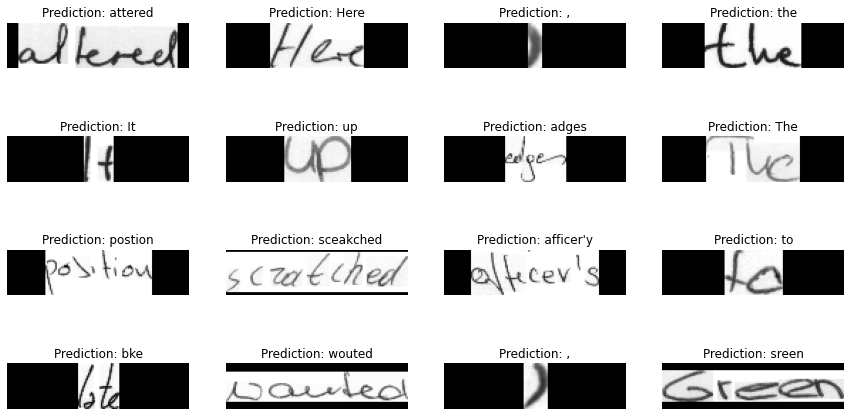

In [99]:
# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
for batch in test_ds:
    batch_images = batch["image"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

## Final remarks

* The `prediction_model` is fully compatible with TensorFlow Lite. If you are interested,
you can use it inside a mobile application. You may find
[this notebook](https://github.com/tulasiram58827/ocr_tflite/blob/main/colabs/captcha_ocr_tflite.ipynb)
to be useful in this regard.
* Not all the training examples are perfectly aligned as observed in this example. This
can hurt model performance for complex sequences. To this end, we can leverage
Spatial Transformer Networks ([Jaderberg et al.](https://arxiv.org/abs/1506.02025))
that can help the model learn affine transformations that maximize its performance.

_Written answer_:

```Number of Epochs``` = 15

| Trianing accuracy | Validation accuracy | Test accuracy |         kernel size          |           strides            |          pool size           |         learning rate         |          optimizer           |      LSTM layers      |      contrast factor       |        flip_on_train        |
| :---------------: | :-----------------: | :-----------: | :--------------------------: | :--------------------------: | :--------------------------: | :---------------------------: | :--------------------------: | :--------------------------: | :------------------------: | :-------------------------: |
|      0.9115       |        0.8125        |    0.8438     |             5,5              |             1,1              |             2,2              |             0.001             |             Adam             |             [200,128,64]              |             3              |             yes             |
|      0.9531       |       0.8125       |    0.9063     | <font color="red">3,3</font> |             1,1              |             2,2              |             0.001             |             Adam             |             [200,128,64]              |             3              |             yes             |
|      0.9167       |        0.6875        |    0.9063     |             5,5              | <font color="red">2,2</font> |             2,2              |             0.001             |             Adam             |             [200,128,64]              |             3              |             yes             |
|      0.8802      |        0.7188        |    0.9063     |             5,5              |             1,1              | <font color="red">3,3</font> |             0.001             |             Adam             |             [200,128,64]              |             3              |             yes             |
|      0.7969       |       0.7500        |    0.9063    |             5,5              |             1,1              |             2,2              | <font color="red">0.01</font> |             Adam             |             [200,128,64]              |             3              |             yes             |
|      0.6198       |       0.4688        |    0.4688    |             5,5              |             1,1              |             2,2              |             0.001             | <font color="red">SGD</font> |             [200,128,64]              |             3              |             yes             |
|      0.9115       |       0.8125       |     0.8438     |             5,5              |             1,1              |             2,2              |             0.001             |             Adam             | <font color="red">[128,64]</font> |             3              |             yes             |
|      0.8750       |       0.6815        |     0.9063      |             5,5              |             1,1              |             2,2              |             0.001             |             Adam             |             [200,128,64]              | <font color="red">2</font> |             yes             |
|      0.8958       |       0.7188        |    0.8438     |             5,5              |             1,1              |             2,2              |             0.001             |             Adam             |             [200,128,64]              |             3              | <font color="red">no</font> |
